In [1]:
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge

In [2]:
# # load pickle from ./data/final
# fixed = np.load('./bsi_zoo/data/final/fixed.pkl', allow_pickle=True)
# fixed_spatialCV = np.load('./bsi_zoo/data/final/fixed_spatialCV.pkl', allow_pickle=True)
fixed = pd.read_csv('./bsi_zoo/data/final/fixed.csv')
fixed_spatialCV = pd.read_csv('./bsi_zoo/data/final/fixed_spatialCV.csv')

/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_15963/2975320679.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  fixed = pd.read_csv('./bsi_zoo/data/final/fixed.csv')


In [3]:
temp = fixed[fixed.estimator == 'iterative_L1']
# drop rows where emd is nan
temp = temp.dropna(subset=['emd'])

xtrue = temp.alpha
xest = temp.reconstructed_noise
X = np.column_stack((xtrue, xest))
ymetric = temp.emd

sigma0 = 0.01
# kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF([0.1, 0.1], (1e-2, 1e2)) + WhiteKernel(sigma0)
# gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, normalize_y=False)
gpr = KernelRidge(kernel="rbf", alpha=1e-2, gamma=1e-1)
# gpr = GaussianProcessRegressor(n_restarts_optimizer=0, normalize_y=False)
gpr.fit(X[::10], ymetric[::10])  # fit on a subset of the data to save time
# gpr.fit(X, ymetric)

KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf')

In [4]:
ymetric.min()

0.0

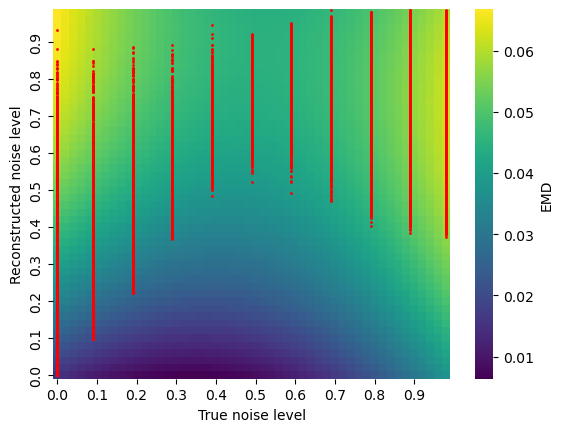

In [8]:
trueSNR = np.arange(0, 1, 0.02)
reconSNR = np.arange(0, 1, 0.02)
gridx, gridy = np.meshgrid(trueSNR, reconSNR)
SNR = np.column_stack((gridx.flatten(), gridy.flatten()))
emdpred = gpr.predict(SNR)
emdpred = emdpred.reshape(gridx.shape)
emdpred = pd.DataFrame(emdpred, columns=reconSNR.round(2), index=trueSNR.round(2))

# makes a heatmap with x axis as trueSNR and y axis as reconSNR and emdpred as color
plt.figure()
ax = sns.heatmap(emdpred, cmap='viridis', cbar_kws={'label': 'EMD'}, xticklabels=5, yticklabels=5);
ax.set_xlabel('True noise level')
ax.set_ylabel('Reconstructed noise level')
ax.invert_yaxis()

ax.plot(X[:, 0] * len(trueSNR), X[:, 1] * len(reconSNR), 'r.', markersize=2)

# # y axis from 0 to 1 label
plt.show()

# # save figure
# plt.savefig('./bsi_zoo/figures/fig2.png', dpi=300, bbox_inches='tight')


In [ ]:
# SNR.shape
emdpred.shape
# emdpred.shape
# WITH SCALING

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the data
df_results = np.load('./bsi_zoo/data/final/fixed.pkl', allow_pickle=True)
cm18 = sns.color_palette("husl", 18)

# Define the performance measures
perf_measures = ['emd', 'euclidean_distance', 'mse', 'f1']

# Group the data by alpha, estimator_alpha, and estimator
grouped = df_results.groupby(['alpha', 'estimator__alpha', 'estimator'])

# Define the grid for plotting GP predictions
alphas_plot = np.arange(0, 1.02, 0.02)
X, Y = np.meshgrid(alphas_plot, alphas_plot)
xx = np.column_stack([X.ravel(), Y.ravel()])

# Loop through performance measures
for iperf in range(len(perf_measures)):
    # Create subplots for each estimator
    for iesti, (estimator, data) in enumerate(grouped):
        xtrue_gp = data['alpha'].values
        xest_gp = data['reconstructed_noise'].values
        y_gp = data[perf_measures[iperf]].values

        # Filter out NaN values
        nan_filter = ~np.isnan(y_gp)
        xtrue_gp = xtrue_gp[nan_filter]
        xest_gp = xest_gp[nan_filter]
        y_gp = y_gp[nan_filter]

        # Standardize the input features
        xtrue_gp = StandardScaler().fit_transform(xtrue_gp.reshape(-1, 1))
        xest_gp = StandardScaler().fit_transform(xest_gp.reshape(-1, 1))

        # Create a Gaussian Process Regressor with an RBF kernel
        kernel = ConstantKernel(1.0) * RBF(1.0)
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gpr.fit(np.column_stack([xtrue_gp, xest_gp]), y_gp)

        # Predict using the GP model
        y_pred, y_std = gpr.predict(xx, return_std=True)

        # Reshape the predictions for plotting
        y_pred = y_pred.reshape(X.shape)
        y_std = y_std.reshape(X.shape)

        # Plot GP posterior mean
        plt.figure()
        sns.heatmap(y_pred, cmap=cm18, xticklabels=False, yticklabels=False, cbar=True)
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('True noise level')
        plt.ylabel('Reconstructed noise level')
        plt.title(f'{perf_measures[iperf]} mean - {estimator}')
        # plt.colorbar(label=f'{perf_measures[iperf]} mean')
        plt.axhline(0, 1, color='k', linestyle='--', linewidth=2)
        plt.plot(xtrue_gp, xest_gp, 'k.', markersize=8)
        # plt.savefig(f'figs/{perf_measures[iperf]}_mean_{estimator}.png', dpi=150, bbox_inches='tight')

        # Plot GP posterior 95th percentile
        plt.figure()
        sns.heatmap(y_pred + 1.96 * y_std, cmap=cm18, xticklabels=False, yticklabels=False, cbar=True)
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('True noise level')
        plt.ylabel('Reconstructed noise level')
        plt.title(f'{perf_measures[iperf]} 95th perc. - {estimator}')
        plt.colorbar(label=f'{perf_measures[iperf]} 95th perc.')
        plt.axhline(0, 1, color='k', linestyle='--', linewidth=2)
        plt.plot(xtrue_gp, xest_gp, 'k.', markersize=8)
        # plt.savefig(f'figs/{perf_measures[iperf]}_95perc_{estimator}.png', dpi=150, bbox_inches='tight')

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler

# Load the data
df_results = pd.read_pickle('./bsi_zoo/data/final/fixed.pkl')
cm18 = sns.color_palette("husl", 18)

# Define the performance measures
perf_measures = ['emd', 'euclidean_distance', 'mse', 'f1']

# Group the data by alpha, estimator_alpha, and estimator
grouped = df_results.groupby(['alpha', 'estimator__alpha', 'estimator'])

# Define the grid for plotting GP predictions
alphas_plot = np.arange(0, 1.02, 0.02)
X, Y = np.meshgrid(alphas_plot, alphas_plot)
xx = np.column_stack([X.ravel(), Y.ravel()])

# Loop through performance measures
for iperf in range(len(perf_measures)):
    # Create subplots for each estimator
    for iesti, (estimator, data) in enumerate(grouped):
        xtrue_gp = data['alpha'].values
        xest_gp = data['reconstructed_noise'].values
        y_gp = data[perf_measures[iperf]].values

        # Filter out NaN values
        nan_filter = ~np.isnan(y_gp)
        xtrue_gp = xtrue_gp[nan_filter]
        xest_gp = xest_gp[nan_filter]
        y_gp = y_gp[nan_filter]

        # Standardize the input features
        xtrue_gp = StandardScaler().fit_transform(xtrue_gp.reshape(-1, 1))
        xest_gp = StandardScaler().fit_transform(xest_gp.reshape(-1, 1))

        # Create a Gaussian Process Regressor with an RBF kernel
        kernel = ConstantKernel(1.0) * RBF(1.0)
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gpr.fit(np.column_stack([xtrue_gp, xest_gp]), y_gp)

        # Predict using the GP model
        y_pred, y_std = gpr.predict(xx, return_std=True)

        # Reshape the predictions for plotting
        y_pred = y_pred.reshape(X.shape)
        y_std = y_std.reshape(X.shape)

        # Plot GP posterior mean
        plt.figure()
        heatmap = sns.heatmap(y_pred, cmap=cm18, xticklabels=False, yticklabels=False, cbar=False)
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('True noise level')
        plt.ylabel('Reconstructed noise level')
        plt.title(f'{perf_measures[iperf]} mean - {estimator}')
        cbar = plt.colorbar(heatmap, label=f'{perf_measures[iperf]} mean')
        plt.axhline(0, 1, color='k', linestyle='--', linewidth=2)
        plt.plot(xtrue_gp, xest_gp, 'k.', markersize=8)
        plt.savefig(f'figs/{perf_measures[iperf]}_mean_{estimator}.png', dpi=150, bbox_inches='tight')

        # Plot GP posterior 95th percentile
        plt.figure()
        heatmap = sns.heatmap(y_pred + 1.96 * y_std, cmap=cm18, xticklabels=False, yticklabels=False, cbar=False)
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('True noise level')
        plt.ylabel('Reconstructed noise level')
        plt.title(f'{perf_measures[iperf]} 95th perc. - {estimator}')
        cbar = plt.colorbar(heatmap, label=f'{perf_measures[iperf]} 95th perc.')
        plt.axhline(0, 1, color='k', linestyle='--', linewidth=2)
        plt.plot(xtrue_gp, xest_gp, 'k.', markersize=8)
        plt.savefig(f'figs/{perf_measures[iperf]}_95perc_{estimator}.png', dpi=150, bbox_inches='tight')

plt.show()


In [ ]:
# Define the performance measures
perf_measures = ['euclidean_distance', 'mse', 'emd', 'f1']

# Define the alphas and estimator_alphas
alphas = fixed.alpha.unique()
estimator_alphas = fixed.estimator__alpha.unique()

# Define the estimators
estimators = fixed.estimator.unique()

In [ ]:

# Define the kernel for Gaussian Process Regression
kernel = 1.0 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

# intialise 3D array with dimensions: alphas, estimator alphas, estimators
xtrue = np.zeros((len(alphas), len(estimator_alphas), len(estimators)))
xtest = np.zeros((len(alphas), len(estimator_alphas), len(estimators)))
y = np.zeros((len(alphas), len(estimator_alphas), len(estimators)))

# loop over alphas, estimator alphas and estimators
for e in range(len(estimators)):
    for a in range(len(alphas)):
        for ea in range(len(estimator_alphas)):
            # get the data for the current combination of alpha, estimator alpha and estimator
            data = fixed[(fixed.alpha == alphas[a]) & (fixed.estimator__alpha == estimator_alphas[ea]) & (fixed.estimator == estimators[e])]
            # get the true performance measure
            xtrue[a, ea, e] = data.alpha.mean()
            # get the test performance measure
            xtest[a, e, e] = data.reconstructed_noise.mean()
            # get the y value
            y[a, ea, e] = data.emd.mean()
            

In [ ]:
for iesti, estimator in enumerate(estimators):
   xtrue_ = xtrue[:, :, iesti]
   xtest_ = xtest[:, :, iesti]
   y_ = y[:, :, iesti]

   # Find the indices for the minimum values
   min_indices = np.argmin(y_, axis=1)
   min_in_2 = np.array([i for i in range(len(xtest_))], min_indices)

   in_nnan = np.where(~np.isnan(y_))
   xtrue_gp = xtrue_[in_nnan]
   xest_gp = xtest_[in_nnan]
   y_gp = y_[in_nnan]

   # Scale the input data
   scaler = StandardScaler()
   xtrue_gp_scaled = scaler.fit_transform(xtrue_gp)
   xest_gp_scaled = scaler.fit_transform(xest_gp)

   # Fit a Gaussian Process Regressor
   gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
   gpr.fit(np.column_stack((xtrue_gp_scaled, xest_gp_scaled)), y_gp)

   alphas_plot = np.arange(0, 1.02, 0.02)
   X, Y = np.meshgrid(alphas_plot, alphas_plot)
   xx = np.column_stack((X.ravel(), Y.ravel()))
   ypred, ystd = gpr.predict(xx, return_std=True)

   ypred = ypred.reshape(X.shape)
   ystd = ystd.reshape(X.shape)

   # Create Seaborn heatmap
   plt.figure()
   sns.heatmap(ypred, cmap="RdYlGn", annot=True, xticklabels=False, yticklabels=False, cbar=True)
   plt.xlabel('True Noise Level')
   plt.ylabel('Reconstructed Noise Level')
   plt.title(estimator)
   plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

# Load your data here

# Define the performance measures
perf_measures = ['EMD', 'log_MSE', 'EUCL', '1-F1']

# Define the alphas and estimator_alphas
# alphas = np.unique(Obj['alpha'])
# estimator_alphas = np.unique(Obj['estimator__alpha'])
alphas = fixed.alpha.unique()
estimator_alphas = fixed.estimator__alpha.unique()

# Define the estimators
# estimators = np.unique(Obj['estimator'], axis=0)
estimators = fixed.estimator.unique()


# Define the kernel for Gaussian Process Regression
kernel = 1.0 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

# Iterate through performance measures
for iperf in range(len(perf_measures)):
    # Initialize data arrays for GP regression
    xtrue = np.zeros((len(alphas), len(estimator_alphas), len(estimators)))
    xest = np.zeros((len(alphas), len(estimator_alphas), len(estimators)))
    y = np.zeros((len(alphas), len(estimator_alphas), len(estimators)))

    # Populate the data arrays
    for iesti, estimator in enumerate(estimators):
        for ia, alpha in enumerate(alphas):
            for iea, estimator_alpha in enumerate(estimator_alphas):
                ind = np.where((Obj['alpha'] == alpha) & (Obj['estimator__alpha'] == estimator_alpha) & (np.all(Obj['estimator'] == estimator, axis=1)))[0]
                xtrue[ia, iea, iesti] = np.mean(Obj['alpha'][ind])
                xest[ia, iea, iesti] = np.mean(Obj['reconstructed_noise'][ind])
                if iperf == 0:
                    y[ia, iea, iesti] = np.mean(Obj['emd'][ind])
                elif iperf == 1:
                    y[ia, iea, iesti] = np.log(np.mean(Obj['mse'][ind]))
                elif iperf == 2:
                    y[ia, iea, iesti] = np.mean(Obj['euclidean_distance'][ind])
                else:
                    y[ia, iea, iesti] = 1 - np.mean(Obj['f1'][ind])

    # Create a Seaborn heatmap for GP regression results
    for iesti, estimator in enumerate(estimators):
        xtrue_ = xtrue[:, :, iesti]
        xest_ = xest[:, :, iesti]
        y_ = y[:, :, iesti]

        # Find the indices for the minimum values
        min_indices = np.argmin(y_, axis=1)
        min_in_2 = np.array([i for i in range(len(xest_))], min_indices)

        in_nnan = np.where(~np.isnan(y_))
        xtrue_gp = xtrue_[in_nnan]
        xest_gp = xest_[in_nnan]
        y_gp = y_[in_nnan]

        # Scale the input data
        scaler = StandardScaler()
        xtrue_gp_scaled = scaler.fit_transform(xtrue_gp)
        xest_gp_scaled = scaler.fit_transform(xest_gp)

        # Fit a Gaussian Process Regressor
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gpr.fit(np.column_stack((xtrue_gp_scaled, xest_gp_scaled)), y_gp)

        alphas_plot = np.arange(0, 1.02, 0.02)
        X, Y = np.meshgrid(alphas_plot, alphas_plot)
        xx = np.column_stack((X.ravel(), Y.ravel()))
        ypred, ystd = gpr.predict(xx, return_std=True)

        ypred = ypred.reshape(X.shape)
        ystd = ystd.reshape(X.shape)

        # Create Seaborn heatmap
        plt.figure()
        sns.heatmap(ypred, cmap="RdYlGn", annot=True, xticklabels=False, yticklabels=False, cbar=True)
        plt.xlabel('True Noise Level')
        plt.ylabel('Reconstructed Noise Level')
        plt.title(estimator)
        plt.show()

        # You can save the figures using plt.savefig() if needed
